In [12]:
import numpy as np
from sklearn.datasets import load_iris
#from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle

In [13]:
def calculate_uncertainty_LeastConfident(X, model):
    # Get predicted probabilities for each class
    predicted_probs = model.predict_proba(X)    
    # Calculate uncertainty scores as the least confident probability
    least_confident = 1 - np.max(predicted_probs, axis=1)    
    return least_confident

def calculate_uncertainty_SmallestMargin(X, model):
    # Get predicted probabilities for each class
    predicted_probs = model.predict_proba(X)    
    # Sort the predicted probabilities in descending order
    sorted_probs = np.sort(predicted_probs, axis=1)[:, ::-1]    
    # Calculate uncertainty scores as the difference between the top two probabilities
    smallest_margin = sorted_probs[:, 0] - sorted_probs[:, 1]    
    return smallest_margin

def calculate_uncertainty_Entropy(X, model):
    # Get predicted probabilities for each class
    predicted_probs = model.predict_proba(X)    
    # Check for zero probabilities and replace them with a small value
    predicted_probs[predicted_probs == 0] = 1e-10
    # Calculate uncertainty scores using the entropy
    entropy = -np.sum(predicted_probs * np.log2(predicted_probs), axis=1)
    # Handle the case of uniform probabilities
    entropy[np.isnan(entropy)] = 0    
    return entropy

def select_uncertain_samples_LC(X, model, n_samples=1):
    uncertainty_scores=calculate_uncertainty_LeastConfident(X, model)   
    # Select the indices of the most uncertain samples
    uncertain_indices = np.argsort(uncertainty_scores)[-n_samples:]    
    return uncertain_indices

def select_uncertain_samples_SM(X, model, n_samples=1):
    uncertainty_scores=calculate_uncertainty_SmallestMargin(X, model)   
    # Select the indices of the most uncertain samples
    #uncertain_indices = np.argsort(uncertainty_scores)[:n_samples]    
    uncertain_indices = np.argsort(uncertainty_scores)[::-1][-n_samples:]
    #np.where(uncertainty_scores == np.min(uncertainty_scores))    
    return uncertain_indices

def select_uncertain_samples_Entropy(X, model, n_samples=1):
    uncertainty_scores=calculate_uncertainty_Entropy(X, model)   
    # Select the indices of the most uncertain samples
    uncertain_indices = np.argsort(uncertainty_scores)[-n_samples:]    
    np.where(uncertainty_scores == np.max(uncertainty_scores))    
    return uncertain_indices

def calculate_uncertainty_Evidence(X_pool, model, TypeOfSelection):
    # Extract the parameters (coefficients/betas) of the trained model
    betas = np.transpose(model.coef_)
    # would sort the array of uncertainties (ent_unc) in descending order, thus giving the indices of the most 
    # uncertain data points at the beginning of the sorted index array.
    evidence_scores = []
    number_features = np.shape(X_pool)[1]
    top_uncertain_indices=np.array([])

    # A loop is initiated over a range of evid_size_data (which is set to 5 * prams['batch_size'] initially but may be adjusted if the pool size is smaller). 
    if TypeOfSelection==1: # All data
       evid_size_data=len(X_pool)  # by Alaa        
    else:
        evid_size_data =  5 * batch_size
        if len(X_pool) <= evid_size_data:
            evid_size_data = len(X_pool)
        ent_unc=calculate_uncertainty_Entropy(X_pool, model)
        sorted_index = np.argsort(-ent_unc, kind='stable')
        top_uncertain_indices  = sorted_index[:5 * batch_size]
    
    # Within the loop, the code calculates evidence scores for each selected data point. For each data point at current_pool_index, 
    # the corresponding instance (current_pool_instance) is extracted from X_pool. The evidence score is computed by multiplying each
    # feature value of the instance (current_pool_instance[i]) with the 
    # corresponding logistic regression coefficient (betasMll[i]). The evidence scores are stored in the list evidence_scores.
    for index in range(evid_size_data): # for each element
        if TypeOfSelection==1:
            current_pool_instance = X_pool[index]           
        else:
            current_pool_index = top_uncertain_indices[index]
            current_pool_instance = X_pool[current_pool_index]            
        
        scores = [current_pool_instance[i]*betas[i] for i in range(number_features)] 
        scores = scores[1:]
        evidence_positive_class = sum([x for x in scores if x > 0])
        evidence_negative_class = sum([-x for x in scores if x < 0])
        evidence_scores.append(evidence_positive_class*evidence_negative_class)
    return evidence_scores,top_uncertain_indices

def select_uncertain_Evidence(X_pool, model, unlabeled_indices_Ev2, n_samples, TypeOfSelection):    
    evidence_scores, top_uncertain_indices=calculate_uncertainty_Evidence(X_pool, model, TypeOfSelection)
    evid_sorted_index = np.argsort(np.array(evidence_scores).reshape(-1,), kind='stable')
    evid_res_size = batch_size
    if len(X_pool) <= evid_res_size:
        evid_res_size = len(X_pool)
    if TypeOfSelection==2: 
        #conflicting_index_pool = top_uncertain_indices[evid_sorted_index[-evid_res_size:]]
        #insufficient_index_pool = top_uncertain_indices[evid_sorted_index[:evid_res_size]]
        top_uncertain_indices2=unlabeled_indices_Ev2[top_uncertain_indices]
        conflicting_index_pool = top_uncertain_indices2[evid_sorted_index[-evid_res_size:]]
        insufficient_index_pool = top_uncertain_indices2[evid_sorted_index[:evid_res_size]]
    else:
        conflicting_index_pool = evid_sorted_index[-n_samples:]
        insufficient_index_pool = evid_sorted_index[0:n_samples]
        
    return conflicting_index_pool, insufficient_index_pool


In [14]:
# Load the Iris dataset
iris = load_iris()
X, y = iris.data[:, :2], iris.target

# Filter the dataset for two classes (class 0 and class 1)
class_indices = np.where((y == 0) | (y == 1))[0]
X = X[class_indices]
y = y[class_indices]
X, y = shuffle(X, y, random_state=42)

In [15]:
# Add column of ones
one_array = np.ones(len(X))
one_array = np.reshape(one_array, (-1,1))
X_evidence = np.append(one_array,X, axis=1)

In [16]:
# Initialize the model (Random Forest Classifier)
model_Evidence = LogisticRegression(fit_intercept=False, solver='liblinear')
model_Evidence2 = LogisticRegression(fit_intercept=False, solver='liblinear')
#model_Entropy = LogisticRegression()

In [17]:
# Select initial labeled samples randomly
labeled_indices = np.random.choice(X.shape[0], size=5, replace=False)
unlabeled_indices = np.setdiff1d(np.arange(X.shape[0]), labeled_indices)

labeled_indices_Ev=labeled_indices
labeled_indices_Ev2=labeled_indices
#labeled_indices_Entropy=labeled_indices

unlabeled_indices_Ev=unlabeled_indices
unlabeled_indices_Ev2=unlabeled_indices
#unlabeled_indices_Entropy=unlabeled_indices

In [18]:
# Start the active learning loop
n_iterations = 10
n_samples_per_iteration = 2
batch_size=1

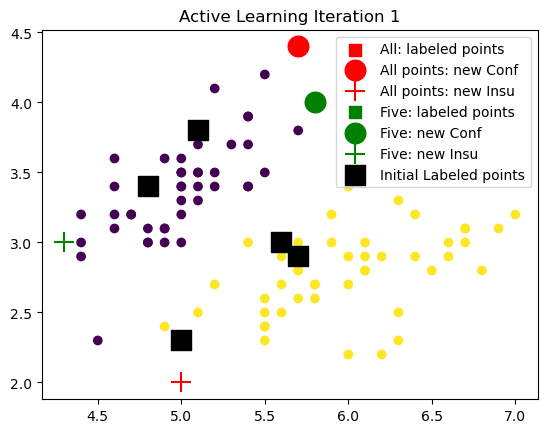

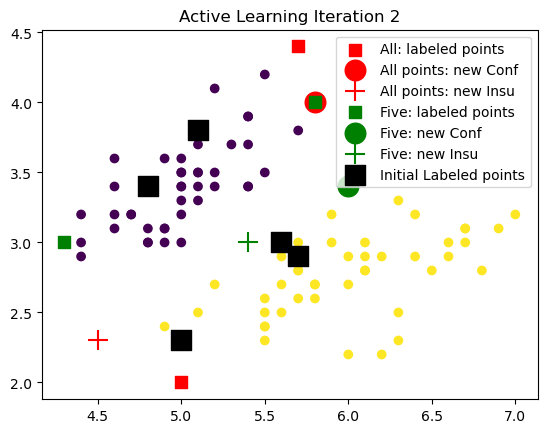

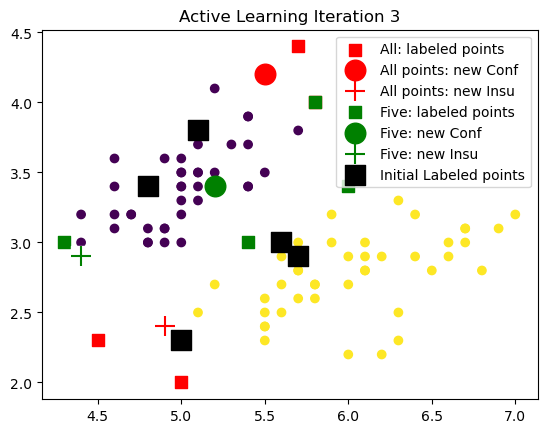

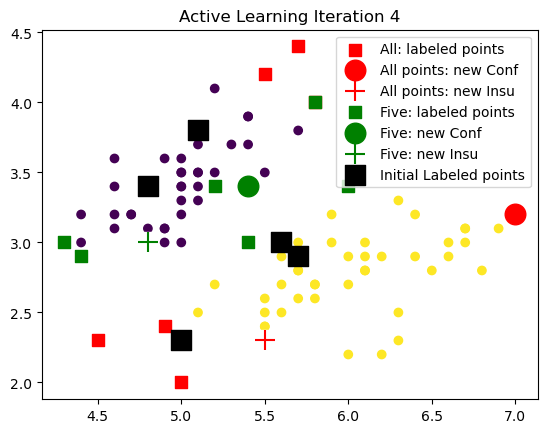

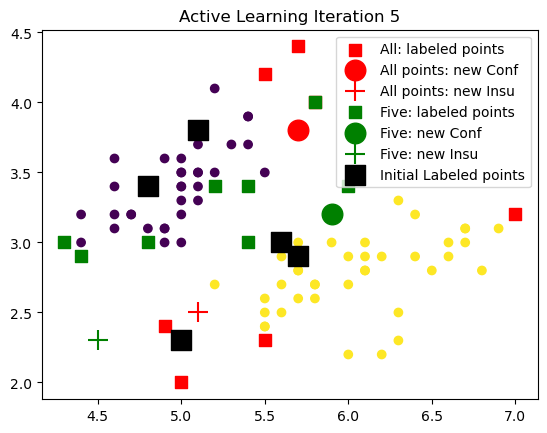

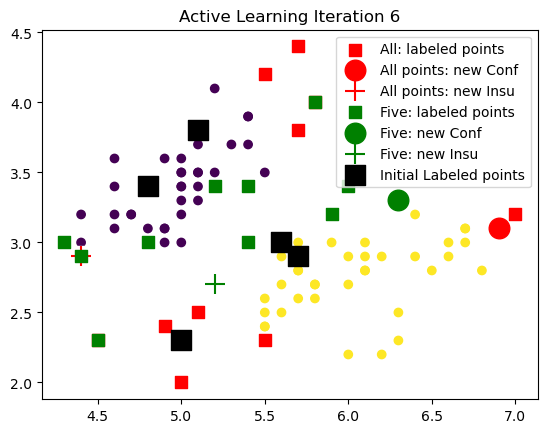

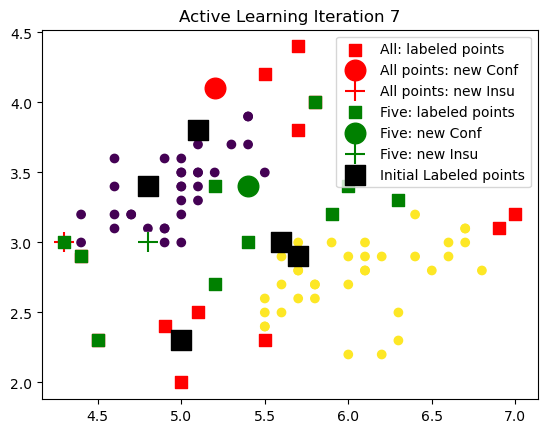

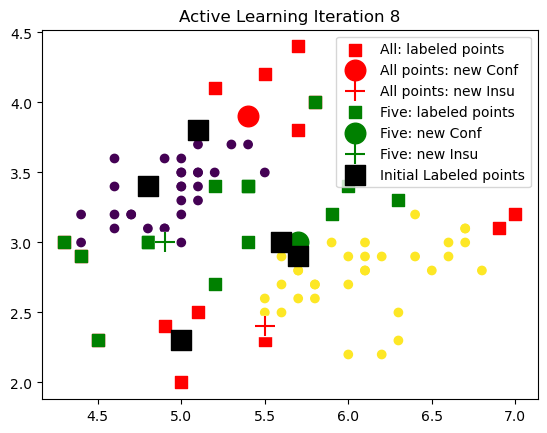

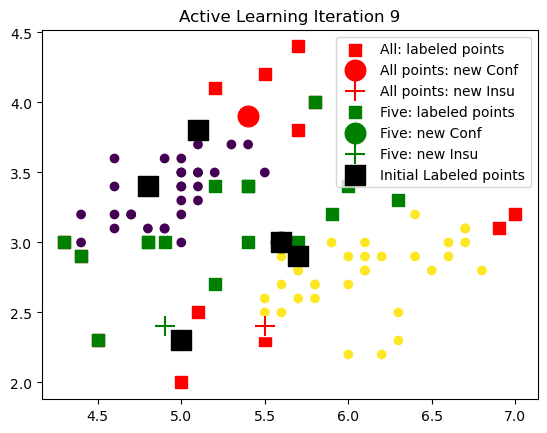

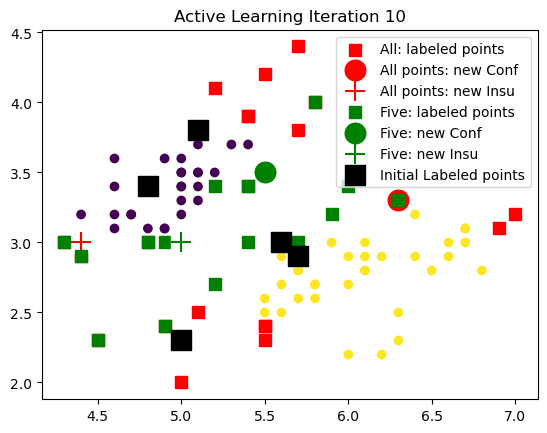

In [19]:
for iteration in range(n_iterations):
    # Train the model on the labeled data
    model_Evidence.fit(X_evidence[labeled_indices_Ev], y[labeled_indices_Ev])
    model_Evidence2.fit(X_evidence[labeled_indices_Ev2], y[labeled_indices_Ev2])
    #model_Entropy.fit(X[labeled_indices_Entropy], y[labeled_indices_Entropy])

    # Select uncertain samples from the unlabeled data
    uncertain_indices_Ev_conf,uncertain_indices_Ev_ins = select_uncertain_Evidence(X_evidence[unlabeled_indices_Ev], model_Evidence,unlabeled_indices_Ev , int(n_samples_per_iteration/2),1)
    uncertain_indices_Ev_conf2,uncertain_indices_Ev_ins2 = select_uncertain_Evidence(X_evidence[unlabeled_indices_Ev2], model_Evidence2, unlabeled_indices_Ev2, int(n_samples_per_iteration/2),2)
    #uncertain_indices_Entropy = select_uncertain_samples_Entropy(X[unlabeled_indices_Entropy], model_Entropy, 5)

    # Query labels for the uncertain samples
    queried_indices_Ev_conf = unlabeled_indices_Ev[uncertain_indices_Ev_conf]
    queried_indices_Ev_ins = unlabeled_indices_Ev[uncertain_indices_Ev_ins]
    queried_indices_Ev_conf2 = uncertain_indices_Ev_conf2
    queried_indices_Ev_ins2 = uncertain_indices_Ev_ins2
    #queried_indices_Entropy = unlabeled_indices_Entropy[uncertain_indices_Entropy[0]]
    #Entropy_indices=unlabeled_indices_Entropy[uncertain_indices_Entropy]
    
    queried_labels_Ev = np.r_[y[queried_indices_Ev_conf],y[queried_indices_Ev_ins]]
    queried_labels_Ev2 = np.r_[y[queried_indices_Ev_conf2],y[queried_indices_Ev_ins2]]
    #queried_labels_Entropy = y[queried_indices_Entropy]

    # Add the queried samples to the labeled set
    labeled_indices_Ev = np.concatenate((labeled_indices_Ev, queried_indices_Ev_conf, queried_indices_Ev_ins))
    labeled_indices_Ev2 = np.concatenate((labeled_indices_Ev2, queried_indices_Ev_conf2, queried_indices_Ev_ins2))
    #labeled_indices_Entropy=np.r_[labeled_indices_Entropy,queried_indices_Entropy]

    # Remove the queried samples from the unlabeled set
    unlabeled_indices_Ev = np.setdiff1d(unlabeled_indices_Ev, np.r_[queried_indices_Ev_conf,queried_indices_Ev_ins])
    unlabeled_indices_Ev2 = np.setdiff1d(unlabeled_indices_Ev2, np.r_[queried_indices_Ev_conf2,queried_indices_Ev_ins2])
    #unlabeled_indices_Entropy = np.setdiff1d(unlabeled_indices_Entropy, queried_indices_Entropy)
    
    # Plot the instance space
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
    plt.scatter(X[labeled_indices_Ev, 0], X[labeled_indices_Ev, 1], marker='s', c='red', label='All: labeled points', s=80)
    plt.scatter(X[labeled_indices_Ev[-2:-1], 0], X[labeled_indices_Ev[-2:-1], 1], marker='o', c='red', label='All points: new Conf', s=220)
    plt.scatter(X[labeled_indices_Ev[-1:], 0], X[labeled_indices_Ev[-1:], 1], marker='s', c='white', s=220)
    plt.scatter(X[labeled_indices_Ev[-1:], 0], X[labeled_indices_Ev[-1:], 1], marker='+', c='red', label='All points: new Insu', s=220)
    plt.scatter(X[labeled_indices_Ev2, 0], X[labeled_indices_Ev2, 1], marker='s', c='green', label='Five: labeled points', s=80)
    plt.scatter(X[labeled_indices_Ev2[-2:-1], 0], X[labeled_indices_Ev2[-2:-1], 1], marker='o', c='green', label='Five: new Conf', s=220)
    plt.scatter(X[labeled_indices_Ev2[-1:], 0], X[labeled_indices_Ev2[-1:], 1], marker='s', c='white', s=220)
    plt.scatter(X[labeled_indices_Ev2[-1:], 0], X[labeled_indices_Ev2[-1:], 1], marker='+', c='green', label='Five: new Insu', s=220)
    plt.scatter(X[labeled_indices_Ev[0:5], 0], X[labeled_indices_Ev[0:5], 1], marker='s', c='black', label='Initial Labeled points', s=220)
    #plt.scatter(X[Entropy_indices, 0], X[Entropy_indices, 1], marker='>', c='black', label='Five: Entropy', s=120)
    #plt.scatter(X[labeled_indices_Entropy[-1:], 0], X[labeled_indices_Entropy[-1:], 1], marker='>', c='red', label='Selected entropy', s=120)
    
  
    plt.title(f'Active Learning Iteration {iteration+1}')
    plt.legend()
    plt.show()